<a href="https://colab.research.google.com/github/carresl/trade-ratings/blob/main/Difference_in_Ratings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Libraries

In [1]:
!pip install ta

In [2]:
!pip install --upgrade yfinance

In [3]:
from google.colab import auth
from google.colab import files
import yfinance as yf
import pandas as pd
from pathlib import Path
import datetime
import pytz
from dateutil.relativedelta import relativedelta
import numpy as np
from ta.momentum import StochRSIIndicator as stoch_rsi
from ta.momentum import RSIIndicator as rsi
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.preprocessing import MinMaxScaler
from numpy.lib.stride_tricks import sliding_window_view
import matplotlib.pyplot as plt
from scipy import stats
# tf libraries
from tensorflow.keras.layers import Dense, Concatenate, LSTM, Input, Embedding, Flatten
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from keras.losses import mean_squared_error as mse

# Parameters

### Ticker list

In [4]:
# 1) Choose which ticker file to read
ticker_file = 'NASDAQ100_2023.csv'
# 2) Choose which ticker list to use
ticker_list = 'Holding Ticker'

### Simulation parameters

In [5]:
# 1) Choose the length of the move which we want to predict (in trading days)
resp_length = 45
# 2) Choose the first date of the simulation
sim_start = datetime.date(2023, 1, 1)
# 3) Set the number of epochs
epochs = 200
# 4) Set the batch size
batches = 64
# 5) Set the regularization lambda value
reg = 0.00005
# 6) Set the patience for Early Stopping
patience = 5
# 7) Choose how often you want the model to be retrained in the simulation (in
#    number of resp_length periods), set to 0 to only train once
retrain_frequency = resp_length * 999999
# 8) Set the starting capital for the simulaiton
nav = 1_000_000
# 9) Specify the risk free asset
risk_free_asset = 'QQQ'
# 10) Specify the number of simulations to run
num_sims = 1
# 11) Rating cutoff (min rating needed)
SR = 1
# 12) Long short or long only
long_short = True
# 13) Choose number of daily candles
num_day_candles = 200

## Data

### Get ticker list from GCloud

In [6]:
# authenticate user
auth.authenticate_user()

# command to copy the data from GCloud
!gsutil -m rsync -r gs://first-aaai-data-bucket/V2_ticker_lists/ /content/

# list of tickers
ai90 = list(set(list(pd.read_csv(ticker_file)[ticker_list])))
ai90 = [a for a in ai90 if isinstance(a, str)]


both the source and destination. Your crcmod installation isn't using the
module's C extension, so checksumming will run very slowly. If this is your
first rsync since updating gsutil, this rsync can take significantly longer than
usual. For help installing the extension, please see "gsutil help crcmod".

Building synchronization state...
Starting synchronization...


### Get the chart data from YFinance



In [7]:
# output the ticker list
print('Tickers being traded:')
print('')
for i, ticker in enumerate(ai90):
    print(f'{i+1}. {ticker}')

Tickers being traded:

1. AEP 
2. PDD 
3. GILD 
4. AMD 
5. ZS 
6. CHTR 
7. GFS 
8. SBUX 
9. WDAY 
10. TMUS 
11. PCAR 
12. EA 
13. WBD 
14. INTU 
15. PEP 
16. CDNS 
17. KLAC 
18. EXC 
19. CRWD 
20. ALGN 
21. LCID 
22. CSGP 
23. SMCI 
24. REGN 
25. ON 
26. TXN 
27. NFLX 
28. ASML 
29. NXPI 
30. CTSH 
31. ILMN 
32. TTWO 
33. BKNG 
34. MNST 
35. ODFL 
36. ROST 
37. VRSK 
38. ARM 
39. FANG 
40. AMZN 
41. MSFT 
42. COST 
43. LULU 
44. TEAM 
45. BIIB 
46. MCHP 
47. MAR 
48. KDP 
49. BKR 
50. CSCO 
51. CMCSA 
52. TSLA 
53. LRCX 
54. IDXX 
55. ISRG 
56. APP 
57. PYPL 
58. AVGO 
59. EBAY 
60. INTC 
61. MRNA 
62. CEG 
63. PAYX 
64. GOOG 
65. XEL 
66. ADI 
67. AAPL 
68. DXCM 
69. GEHC 
70. ADSK 
71. AZN 
72. QCOM 
73. MRVL 
74. MELI 
75. KHC 
76. ZM 
77. JD 
78. ORLY 
79. GOOGL 
80. CPRT 
81. MU 
82. META 
83. CTAS 
84. ENPH 
85. TTD 
86. NVDA 
87. FAST 
88. AMGN 
89. PANW 
90. SNPS 
91. MDLZ 
92. ABNB 
93. FTNT 
94. ANSS 
95. HON 
96. CSX 
97. VRTX 
98. ADP 
99. AMAT 
100. DDOG 
101. ADBE 


In [8]:
# download day, week, and month charts
day_charts = [yf.download(ticker, period = 'max', interval = '1d') for ticker in ai90]

# drop the multi-level
for d in day_charts:
    d['symbol'] = d.columns.get_level_values(1)[0]
    d.columns = d.columns.droplevel(1)

# reset index to get Date column
day_charts = [d.reset_index() for d in day_charts]

/tmp/ipython-input-8-2556899330.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  day_charts = [yf.download(ticker, period = 'max', interval = '1d') for ticker in ai90]
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-8-2556899330.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  day_charts = [yf.download(ticker, period = 'max', interval = '1d') for ticker in ai90]
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-8-2556899330.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  day_charts = [yf.download(ticker, period = 'max', interval = '1d') for ticker in ai90]
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-8-2556899330.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  day_charts = [yf.download(ticker, period = 'max', interval =

### Function to preprocess data

In [9]:
def train_daily(data, length, resp_length, first_date=pd.to_datetime('2017-01-01')):
    '''
    Training data for daily candles

    Params:
        1. data: list of daily charts
        2. length: number of daily candles in each time series
        3. resp_length: number of days to hold each position
        4. first_date: cutoff date for the training data
    '''

    # 0) get the final data after cutoff date and get y variable
    data = [d[(d['Date'].dt.date >= first_date.date())] for i, d in enumerate(data)]
    for i, d in enumerate(data):
        dc = d.copy()
        dc['price_final'] = dc['Open'].shift(-(resp_length+1))
        dc['price_initial'] = dc['Open'].shift(-1)
        dc = dc[dc['price_final'] > 0]
        dc['Change'] = (dc['price_final'] - dc['price_initial']) / dc['price_initial']
        dc = dc.drop(columns=['price_final', 'price_initial'])
        data[i] = dc
    total_obs = sum([len(d)-length+1 for d in data])
    # 1) get the month_change, date and ticker information for each day of each ticker
    dates = np.zeros(total_obs, dtype=object)
    resp = np.zeros(total_obs)
    tickers = np.zeros(total_obs)
    ci = 0
    for i, d in enumerate(data):
        dates_vec = d['Date'].dt.date.values
        resp_vec = d['Change'].values
        tickers_vec = d['symbol'].values
        tickers_vec = np.ones(shape=tickers_vec.shape)*i
        fdv = dates_vec[length-1:]
        frv = resp_vec[length-1:]
        ftv = tickers_vec[length-1:]
        dates[ci:ci+fdv.shape[0]] = fdv
        resp[ci:ci+frv.shape[0]] = frv
        tickers[ci:ci+ftv.shape[0]] = ftv
        ci += fdv.shape[0]
    dates = dates.reshape((-1,1))
    resp = resp.reshape((-1,1))
    tickers = tickers.reshape((-1,1))
    # 2) put the data into SWV & normalize (the -3 here is for the 3 cols that we drop)
    data_swv = np.zeros((total_obs, length, len(data[0].columns)-3))
    # track the total number of entries
    si = 0
    # standard scaler
    scaler = StandardScaler()
    for k, d in enumerate(data):
        d_numerical = d.drop(['Date', 'symbol', 'Change'], axis=1)
        dnp = d_numerical.values
        dnp = sliding_window_view(dnp, window_shape=length, axis=0)
        dnp_fin = np.moveaxis(dnp, 2,1)
        # normalize each 30 day window independently
        for i in range(dnp_fin.shape[0]):
            # separate the price columns
            d_price = dnp_fin[i,:,:4]
            # the volume column
            d_vol = dnp_fin[i,:,4]
            d_ema = dnp_fin[i,:,5:]
            # normalize the volume
            d_vol = scaler.fit_transform(d_vol.reshape(-1,1))
            d_vol = d_vol.reshape(-1)
            d_price = scaler.fit_transform(d_price.reshape(-1,1))
            d_price = d_price.reshape((-1,4))
            data_swv[si,:,:4] = d_price
            data_swv[si,:,4] = d_vol
            data_swv[si,:,5:] = d_ema
            si += 1
    return data_swv, resp, dates, tickers

### Getting the final data

In [10]:
# final chart data
X, y, dates, tickers = train_daily(day_charts, num_day_candles, resp_length)

/tmp/ipython-input-9-1402510762.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dc['Change'] = (dc['price_final'] - dc['price_initial']) / dc['price_initial']


In [11]:
# verify the shapes are correct
print(X.shape, y.shape, dates.shape, tickers.shape)

(179770, 200, 5) (179770, 1) (179770, 1) (179770, 1)


## Simulation Functions

### Model Architecture

In [12]:
def define_model(daily_candles, daily_features, num_tickers, regularization):
    '''
    Defines the neural network model that will be used to make predictions

    Params:
        1. daily_candles: number of daily candles in each observation
        2. daily_features: number of features per candle (includes EMAs)
        3. num_tickers: number of tickers in the data set
        4. regularization: lambda value for regularization
    '''

    # input layer
    day_input = Input(shape=(daily_candles, daily_features), name='Daily Charts')
    # LSTM layers
    lo1 = LSTM(units=64,
               return_sequences=True,
               kernel_regularizer=l2(regularization),
               recurrent_regularizer=l2(regularization)
               )(day_input)
    ls1 = LSTM(units=32,
              return_sequences=False,
              kernel_regularizer=l2(regularization),
              recurrent_regularizer=l2(regularization)
              )(lo1)
    # hidden layers
    initializer = HeNormal()
    hidden1 = Dense(units=64,
                    kernel_initializer=initializer,
                    kernel_regularizer=l2(regularization),
                    activation='leaky_relu')(ls1)
    hidden2 = Dense(units=32,
                    kernel_initializer=initializer,
                    kernel_regularizer=l2(regularization),
                    activation='leaky_relu')(hidden1)
    # output layer
    output = Dense(1,name='Output')(hidden2)
    # define the model & compile
    model = Model(inputs=day_input, outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    return model

### Function to get market return

In [13]:
def get_risk_free(rfa, resp_length, di, df):
    '''
    Calculates a risk-free rate based on either a defined risk-free rate or
    based on a specified asset

    Params:
        1. rfa: if str, then calculate the average return of the asset over the
                specified holding period during the training period
        2. resp_length: the holding period for each trade
        3. di: the start date of the training data
        4. df: the end date of the training data
    '''

    # if risk_free_asset is an asset rather than a constant value
    if isinstance(rfa, str):
        # download the chart
        rf = yf.download(rfa, start=di, end=df)
        rf.columns = rf.columns.droplevel(1)
        # calculate the average gain over each resp_length period
        rf['shifted'] = rf['Open'].shift(-resp_length)
        rf['return'] = (rf['shifted'] - rf['Open']) / rf['Open']
        rf = rf[rf.index.date <= df]
        rf_return = rf['return'].mean()
    else:
        rf_return = rfa
    print('\n')
    print(f'risk free return: {rf_return}')
    return rf_return

### Simulation Function

In [14]:
def simulate_trades(dates, start_date, time_length, data_d,
                    data_tick, resp, ticker_list, risk_free,
                    rf, num_epochs, batches, reg, patience, sr_rating, l_s,
                    start_nav = 1_000_000):
    '''
    Runs the full trade simulation

    Params:
        1. dates: np.array of all the dates for which we have data
        2. start_date: the start date of the sim
        3. time_length: the holding period for all trades
        4. data_d: np.array of daily charts training data
        5. data_tick: np.array of tickers corresponding to the charts
        6. resp: np.array of the response variable data
        7. ticker_list: list of all tickers in the training data set
        8. risk_free: the risk free asset/return
        9. rf: the frequency with which the model will be re-trained with updated data
        10. num_epochs: number of epochs in training
        11. batches: number of batches in training
        12. reg: lambda value for regularization
        13. patience: patience for early stopping in training
        14. sr_rating: minimum rating needed to enter a trade
        15. l_s: if True long/short strategy else long only
        16. start_nav: starting net asset value for the simulation
    '''

    # get the trading days in order
    trading_days = list(set(dates[dates >= start_date]))
    trading_days.sort()
    # starting nav and capital allocation
    curr_nav = start_nav
    prev_nav = start_nav
    # early stopping
    early_stopping = EarlyStopping(monitor='mse',
            patience=patience, restore_best_weights=True,
            verbose=1)
    # MinMaxScaler
    scaler = MinMaxScaler()
    # ticker_specific_rmse
    ticker_specific_rmse ={}
    # if the df gets created
    df_created = False
    sim_report = pd.DataFrame()
    # for retraining
    train_min_day = None
    for i, day in enumerate(trading_days):
        # rebalance the port after each time step
        if i % time_length != 0: continue
        # mask the dates array
        if not train_min_day: train_mask = (dates<day - datetime.timedelta((int(time_length*1.75)+time_length))) & (dates >= (day - datetime.timedelta(int(time_length*1.75)+(4*365)))) # within the past 4 years for training data
        else: train_mask = (dates<day - datetime.timedelta((int(time_length*1.75)+time_length))) & (dates >= train_min_day) # only data which the model has not already seen
        val_mask = (dates<day) & (dates >= (day - datetime.timedelta(time_length)))
        test_mask = dates==day
        train_mask = train_mask.squeeze()
        test_mask = test_mask.squeeze()
        val_mask = val_mask.squeeze()
        # inference data
        inf_d = data_d[test_mask]
        inf_tick = data_tick[test_mask]
        moves = resp[test_mask]
        inf_tick = inf_tick.astype(np.int32)
        # number of tickers
        num_tickers = len(ticker_list)
        if i % rf == 0:
            train_min_day = day
            print(f'max training day: {dates[train_mask].max()}, min training day: {dates[train_mask].min()}')
            # training data
            train_d = data_d[train_mask]
            train_tick = data_tick[train_mask]
            train_resp = resp[train_mask]
            train_tick = train_tick.astype(np.int32)
            # validation data
            val_d = data_d[val_mask]
            val_tick = data_tick[val_mask]
            val_resp = resp[val_mask]
            val_tick = val_tick.astype(np.int32)
            # define the model
            if i == 0:
                model = define_model(train_d.shape[1], train_d.shape[-1],
                                    num_tickers=num_tickers, regularization=reg)
            model.fit(x=train_d,
                      y=train_resp,
                      validation_data=(val_d, val_resp),
                      epochs=num_epochs, batch_size=batches,
                      callbacks=early_stopping, verbose=1)
            # get the ticker specific error rate
            val_preds = model.predict(val_d)
            full_mse = mse(val_resp.squeeze(), val_preds.squeeze())
            full_rmse = np.sqrt(full_mse)
            uni_tickers = np.unique(val_tick)
            for ticker in uni_tickers:
                ticker_mask = val_tick == ticker
                ticker_mask = ticker_mask.squeeze()
                ticker_train_preds = val_preds.squeeze()
                ticker_train_moves  = val_resp.squeeze()
                ticker_train_preds = ticker_train_preds[ticker_mask]
                ticker_train_moves = ticker_train_moves[ticker_mask]
                # get rmse
                ticker_train_mse = mse(ticker_train_moves, ticker_train_preds)
                ticker_train_rmse = np.sqrt(ticker_train_mse)
                ticker_specific_rmse[ticker] = ticker_train_rmse
            # print to check
            print(ticker_specific_rmse)
            # get the risk_free return
            train_days = dates[train_mask]
            rfr = get_risk_free(risk_free, resp_length, train_days.min(), train_days.max())
            # print to ensure no leakage
            print(train_days.min(), train_days.max())
        # preds
        print(day)
        preds = model.predict(inf_d)
        preds = preds.squeeze()
        moves = moves.squeeze()
        inf_tick = inf_tick.squeeze()
        # divide them by the ticker specific risk
        sharpe_scores = np.zeros(preds.shape[0])
        specific_rmses =  np.zeros(preds.shape[0])
        ticker_sds =  np.zeros(preds.shape[0])
        for j, pos_score in enumerate(zip(inf_tick.squeeze(), preds)):
            # get rmse for each position and divide the score by it
            sd_risk = ticker_specific_rmse.get(pos_score[0], -1)
            if sd_risk < 0:
                ticker_sd = full_rmse
                sharpe_score = (pos_score[1] - rfr) / ticker_sd
                # if ticker was not in the training set based on the split use
                # the overall training RMSE
                specific_rmse = False
            else:
                ticker_sd = sd_risk
                sharpe_score = (pos_score[1] - rfr) / ticker_sd
                specific_rmse = True
            sharpe_scores[j] = sharpe_score
            ticker_sds[j] = ticker_sd
            specific_rmses[j] = specific_rmse
        # go long if the pred > 0 and sharpe_scores > 1
        mask_pred = preds > 0
        mask_sharpe = sharpe_scores > sr_rating
        final_mask = mask_pred * mask_sharpe
        # mask to get the long positions
        long_moves = moves[final_mask]
        long_ratings = sharpe_scores[final_mask]
        # short side
        mask_short_pred = preds < 0
        if l_s: mask_short_sharpe = sharpe_scores < -sr_rating
        else:  mask_short_sharpe = sharpe_scores < -999999999
        final_short_mask = mask_short_pred * mask_short_sharpe
        # mask to get the short positions
        short_moves = moves[final_short_mask]
        short_ratings = sharpe_scores[final_short_mask]
        # if there are no trades
        if long_ratings.shape[0] == short_ratings.shape[0] == 0: continue
        # outputs to the df
        final_ratings = np.concatenate([long_ratings, short_ratings])
        final_moves = np.concatenate([long_moves, short_moves])
        temp = pd.DataFrame()
        temp['Rating'] = np.round(final_ratings, 4)
        temp['Gain'] = np.round(final_moves, 4)
        if not df_created:
            sim_report = temp
            df_created = True
        else: sim_report = pd.concat([sim_report, temp], axis=0)
    return sim_report

### Hidden parameters

In [15]:
# keep track of the sims
sim_number = 1
curr_date = datetime.date.today()

In [16]:
# number of tickers for the embedding layer
num_tickers = len(ai90)

In [17]:
# array to store sim results
PLs = [0]*num_sims

# Simulations

### Run the simulation

In [18]:
simulation_report = simulate_trades(dates, sim_start, resp_length,
                                    X, tickers, y, ai90,
                                    risk_free_asset,
                                    retrain_frequency, epochs,
                                    batches, reg, patience, SR,
                                    long_short, nav)
# download the simulation report
sim_file = f'{curr_date}_simulation_report_{sim_number}.csv'
simulation_report.to_csv(sim_file, index=False)
files.download(sim_file)

max training day: 2022-09-01, min training day: 2018-10-18
Epoch 1/200
1419/1419 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - loss: 0.0471 - mse: 0.0332 - val_loss: 0.0339 - val_mse: 0.0286
Epoch 2/200
1419/1419 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - loss: 0.0350 - mse: 0.0309 - val_loss: 0.0292 - val_mse: 0.0273
Epoch 3/200
1419/1419 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - loss: 0.0324 - mse: 0.0308 - val_loss: 0.0273 - val_mse: 0.0263
Epoch 4/200
1419/1419 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - loss: 0.0320 - mse: 0.0312 - val_loss: 0.0278 - val_mse: 0.0271
Epoch 5/200
1419/1419 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - loss: 0.0303 - mse: 0.0297 - val_loss: 0.0292 - val_mse: 0.0285
Epoch 6/200
1419/1419 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - loss: 0.0305 - mse: 0.0298 - val_loss: 0.0279 - val_mse: 0.0272
Epoch 7/200
1419/1419 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - loss: 0.0298 - mse: 0.0291 - val_loss: 0.0309 - val_mse: 0.0301
Epoch 8/200
1419/1419 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - loss: 0.0296 - mse: 0

/tmp/ipython-input-13-1585781058.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  rf = yf.download(rfa, start=di, end=df)
[*********************100%***********************]  1 of 1 completed



risk free return: 0.035553646505545315
2018-10-18 2022-09-01
2023-01-03
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2023-03-09
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2023-05-12
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2023-07-19
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2023-09-21
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2023-11-24
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2024-01-31
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2024-04-05
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2024-06-10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2024-08-14
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2024-10-17
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2024-12-20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2025-02-28
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Results

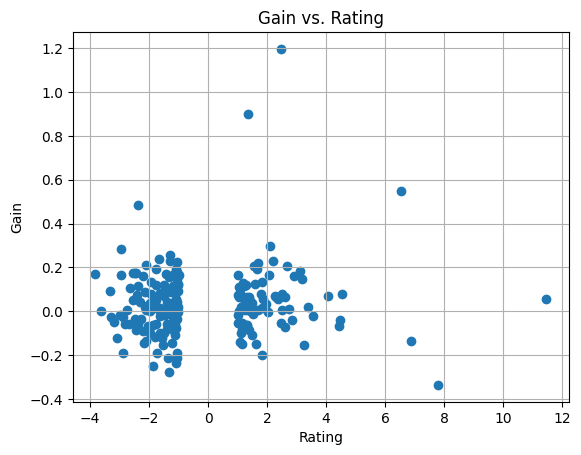

In [19]:
# scatter plot to compare PL% vs Rating for each trade
plt.scatter(simulation_report['Rating'], simulation_report['Gain'])
plt.xlabel('Rating')
plt.ylabel('Gain')
plt.title('Gain vs. Rating')
plt.grid(True)
plt.show()

In [20]:
# correlation
print(f'Correlation between ratings and gains: {np.round(simulation_report["Rating"].corr(simulation_report["Gain"]), 4)}')

Correlation between ratings and gains: 0.0872


In [21]:
# T-Test
positive_ratings = simulation_report[simulation_report['Rating'] > 1]['Gain'].values
negative_ratings = simulation_report[simulation_report['Rating'] < -1]['Gain'].values
t_stat, p_val = stats.ttest_ind(positive_ratings, negative_ratings, alternative='greater')
print(f'Average gain for ratings > 1: {np.round(positive_ratings.mean(), 4)}')
print(f'Average gain for ratings < -1: {np.round(negative_ratings.mean(), 4)}')
print(f't-statistic: {np.round(t_stat, 4)}')
print(f'p-value: {np.round(p_val, 4)}')

Average gain for ratings > 1: 0.0593
Average gain for ratings < -1: 0.0211
t-statistic: 1.6913
p-value: 0.0462
